# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score, recall_score

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("/kaggle/input/uci-har/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("/kaggle/input/uci-har/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("/kaggle/input/uci-har/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("/kaggle/input/uci-har/UCI HAR Dataset/test/y_test.txt").astype(int)

In [5]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [7]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [10]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [11]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [12]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

**Ответ:** 65

In [14]:
# Ваш код здесь
print(f"Количество компонент: {pca.n_components_}")
print(f"Суммарная дисперсия: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Общее количество компонент: {X_scaled.shape[1]}")

Количество компонент: 65
Суммарная дисперсия: 0.9005
Общее количество компонент: 561


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

**Ответ:** 51

In [15]:
# Ваш код здесь
first_component_variance = pca.explained_variance_ratio_[0]
print(f"Доля дисперсии первой компоненты: {first_component_variance:.4f} ({first_component_variance*100:.1f}%)")

Доля дисперсии первой компоненты: 0.5074 (50.7%)


Визуализируйте данные в проекции на первые две главные компоненты.

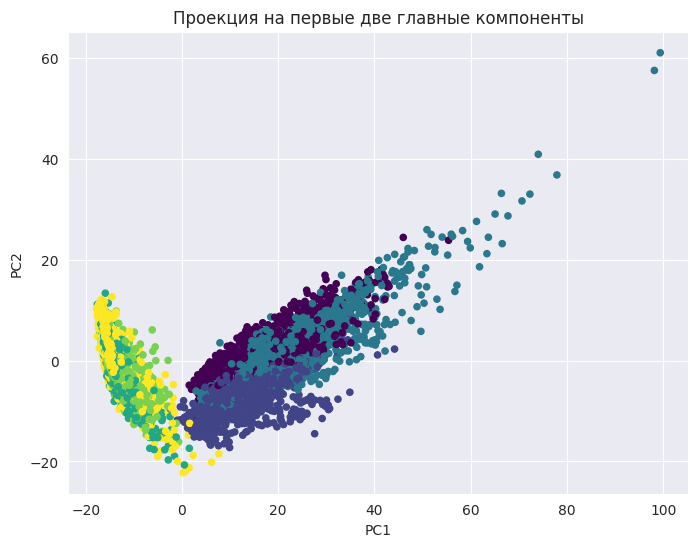

In [16]:
# Ваш код здесь
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.title('Проекция на первые две главные компоненты')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [17]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

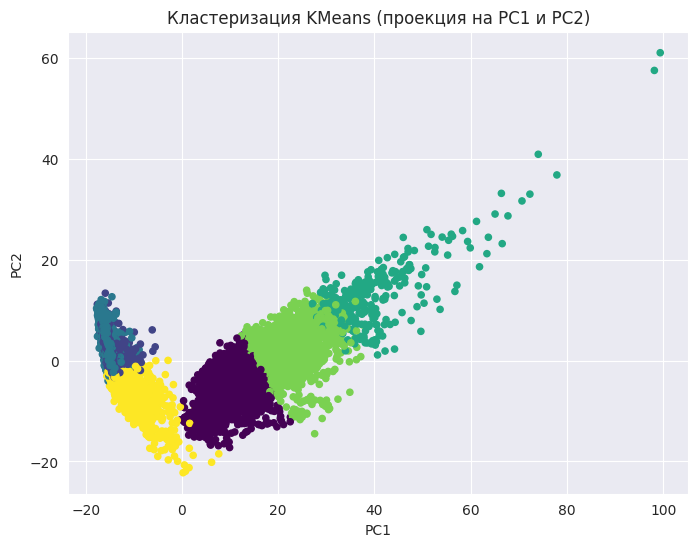

In [21]:
# Ваш код здесь
cluster_labels = kmeans.labels_
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.title('Кластеризация KMeans (проекция на PC1 и PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [22]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
перечисленные варианты не подходят, так как лучше всего от остальных отделился подъем вверх по лестнице (1241/1544 =0,804)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

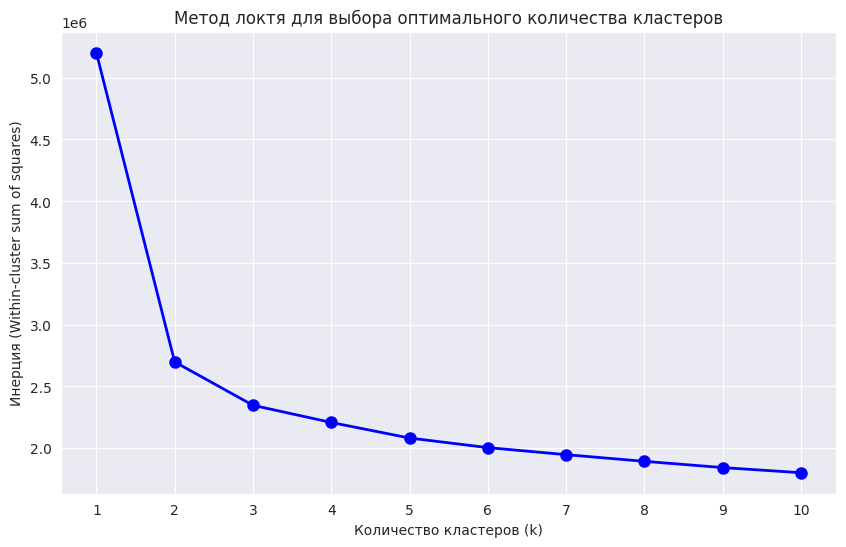

Анализ метода локтя для k=1-4:
k=1: инерция = 5202757.68
k=2: инерция = 2697926.76
k=3: инерция = 2346425.10
k=4: инерция = 2207131.82


In [23]:
# Ваш код здесь
inertia = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (Within-cluster sum of squares)')
plt.title('Метод локтя для выбора оптимального количества кластеров')
plt.grid(True)
plt.xticks(k_range)
plt.show()

print("Анализ метода локтя для k=1-4:")
for k in range(1, 5):
    print(f"k={k}: инерция = {inertia[k-1]:.2f}")

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
3
График инерции показывает "локоть" (изгиб) при k=3, где дальнейшее увеличение количества кластеров даёт всё меньший выигрыш в уменьшении инерции. После 3 кластеров уменьшение инерции становится менее выраженным, что указывает на оптимальность выбора k=3.

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [24]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [27]:
# Ваш код здесь
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag = metrics.adjusted_rand_score(y, ag.labels_)
print(f"Adjusted Rand Index:")
print(f"  KMeans: {ari_kmeans:.4f}")
print(f"  Agglomerative Clustering: {ari_ag:.4f}")

Adjusted Rand Index:
  KMeans: 0.4198
  Agglomerative Clustering: 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:** (все верно)
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [28]:
# Ваш код здесь
#
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [33]:
# Ваш код здесь
best_svc = GridSearchCV(
    svc, 
    svc_params, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  
)

best_svc.fit(X_train_scaled, y_train)

print(f"Лучший параметр C: {best_svc.best_params_['C']}")
print(f"Лучшая точность на кросс-валидации: {best_svc.best_score_:.4f}")
print(f"Точность на тестовой выборке: {best_svc.score(X_test_scaled, y_test):.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Лучший параметр C: 0.1
Лучшая точность на кросс-валидации: 0.9383
Точность на тестовой выборке: 0.9623


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.1

In [34]:
y_predicted = best_svc.predict(X_test_scaled)

In [44]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

activities = tab.columns 

precision = precision_score(y_test, y_predicted, average=None)
recall = recall_score(y_test, y_predicted, average=None)

print("\nТочность и полнота по классам:")
for i, act in enumerate(activities[:-1]):
    print(f"{act}: Точность={precision[i]:.3f}, Полнота={recall[i]:.3f}")

worst_precision = activities[np.argmin(precision)]
worst_recall = activities[np.argmin(recall)]

print(f"\nХудшая точность: {worst_precision}")
print(f"Худшая полнота: {worst_recall}")


Точность и полнота по классам:
ходьба: Точность=0.972, Полнота=0.996
подъем вверх по лестнице: Точность=0.981, Полнота=0.975
спуск по лестнице: Точность=1.000, Полнота=0.986
сидение: Точность=0.964, Полнота=0.868
стояние: Точность=0.878, Полнота=0.972
лежание: Точность=1.000, Полнота=0.980

Худшая точность: стояние
Худшая полнота: сидение


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
 по точности – сидение, по полноте – стояние

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%

**Ответ:** 4%

In [47]:
pca_svc = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_svc.fit_transform(X_train_scaled)
X_test_pca = pca_svc.transform(X_test_scaled)

grid_svc_pca = GridSearchCV(LinearSVC(random_state=RANDOM_STATE, max_iter=5000, dual=False), 
                           svc_params, cv=3)
grid_svc_pca.fit(X_train_pca, y_train)

diff = round((best_svc.best_score_ - grid_svc_pca.best_score_) * 100)
print(f"Разница в качестве: {diff}%")

Разница в качестве: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:** 2,3 утверждения

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

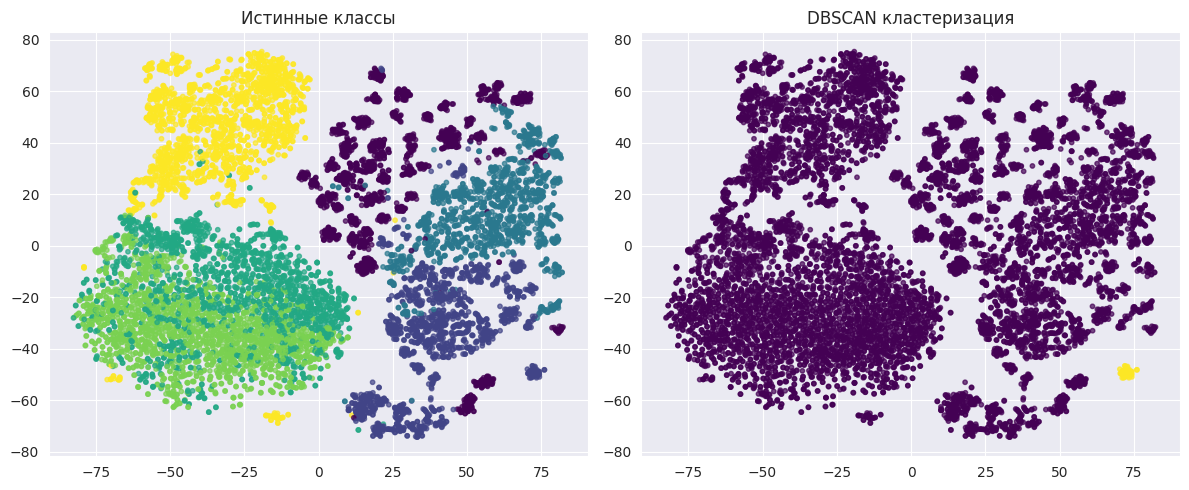

Кластеров: 2
Шумовых точек: 0 (0.0%)


In [48]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

dbscan = DBSCAN(eps=10, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=10, cmap='viridis', alpha=0.7)
plt.title('Истинные классы')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=10, cmap='viridis', alpha=0.7)
plt.title('DBSCAN кластеризация')

plt.tight_layout()
plt.show()


n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Кластеров: {n_clusters}")
print(f"Шумовых точек: {n_noise} ({n_noise/len(X_tsne)*100:.1f}%)")

In [49]:
ari_dbscan = metrics.adjusted_rand_score(y, dbscan_labels)
print(f"ARI (DBSCAN): {ari_dbscan:.4f}")

ARI (DBSCAN): 0.0006
